In [1]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
%pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("../data/df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "../data/coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [3]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [4]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [5]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [6]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [7]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


In [ ]:
## DON'T RUN

# Define debris flow events (max 15-minute gap allowed)
def identify_debris_flow_events(df, max_gap_minutes=15):
    """
    Identify continuous debris flow events with allowed gaps.
    """
    # Sort by time
    df = df.sort_values('time_minute').copy()
    
    # Find where debris flow = 1
    debris_times = df[df['debris flow'] == 1]['time_minute'].unique()
    debris_times = pd.Series(sorted(debris_times))
    
    if len(debris_times) == 0:
        df['event_id'] = 0
        return df, pd.DataFrame()
    
    # Calculate time gaps between consecutive debris flow minutes
    time_diffs = debris_times.diff()
    
    # Start new event when gap > max_gap_minutes OR at the very first debris flow
    event_breaks = (time_diffs > pd.Timedelta(minutes=max_gap_minutes)) | (time_diffs.isna())
    event_ids = event_breaks.cumsum()  # This now starts at 1 for the first event
    
    # Create mapping from time to event_id
    time_to_event = pd.DataFrame({
        'time_minute': debris_times,
        'event_id': event_ids.values
    })
    
    # Merge back to main dataframe
    df = df.merge(time_to_event, on='time_minute', how='left')
    df['event_id'] = df['event_id'].fillna(0).astype(int)
    
    # Create event summary
    events_summary = (df[df['event_id'] > 0]
                     .groupby('event_id')
                     .agg({
                         'time_minute': ['min', 'max', 'count'],
                     }))
    events_summary.columns = ['start_time', 'end_time', 'n_minutes']
    events_summary['duration_min'] = (
        (events_summary['end_time'] - events_summary['start_time']).dt.total_seconds() / 60
    )
    
    return df, events_summary

df_june, events_summary = identify_debris_flow_events(df_june, max_gap_minutes=15)

print(f"\n  Debris flow events identified: {len(events_summary)}")
if len(events_summary) > 0:
    print(f"  Event durations (minutes): {events_summary['duration_min'].describe().to_dict()}")
    print("\n  Event details:")
    for event_id, row in events_summary.iterrows():
        print(f"    Event {event_id}: {row['start_time']} to {row['end_time']} "
              f"({row['duration_min']:.0f} min, {row['n_minutes']} readings)")

# Filter to keep only 30-minute windows before and after each event
if len(events_summary) > 0:
    window_minutes = 30
    
    # Create list of time ranges to keep
    keep_mask = pd.Series(False, index=df_june.index)
    
    for event_id, row in events_summary.iterrows():
        event_start = row['start_time']
        event_end = row['end_time']
        
        # Define window: 30 min before event to 30 min after event
        window_start = event_start - pd.Timedelta(minutes=window_minutes)
        window_end = event_end + pd.Timedelta(minutes=window_minutes)
        
        # Mark rows in this window
        in_window = (df_june['time_minute'] >= window_start) & (df_june['time_minute'] <= window_end)
        keep_mask |= in_window
        
        print(f"\n    Event {event_id} window: {window_start} to {window_end}")
    
    # Filter dataframe
    df_june_windowed = df_june[keep_mask].copy()
    
    print(f"\n  Original data: {len(df_june)} timepoints")
    print(f"  Windowed data: {len(df_june_windowed)} timepoints")
    print(f"  Reduction: {100 * (1 - len(df_june_windowed)/len(df_june)):.1f}%")
    
    # Use the windowed data for subsequent analysis
    df_june = df_june_windowed
else:
    print("\n  No debris flow events found - keeping all data")


  Debris flow events identified: 8
  Event durations (minutes): {'count': 8.0, 'mean': 107.5, 'std': 72.53570549342284, 'min': 15.0, '25%': 47.0, '50%': 115.5, '75%': 154.0, 'max': 220.0}

  Event details:
    Event 1: 2020-06-04 14:51:00 to 2020-06-04 17:21:00 (150 min, 906 readings)
    Event 2: 2020-06-07 07:10:00 to 2020-06-07 09:56:00 (166 min, 1002 readings)
    Event 3: 2020-06-08 13:38:00 to 2020-06-08 14:33:00 (55 min, 336 readings)
    Event 4: 2020-06-08 14:50:00 to 2020-06-08 15:13:00 (23 min, 144 readings)
    Event 5: 2020-06-08 15:44:00 to 2020-06-08 15:59:00 (15 min, 96 readings)
    Event 6: 2020-06-08 16:36:00 to 2020-06-08 18:45:00 (129 min, 780 readings)
    Event 7: 2020-06-17 03:18:00 to 2020-06-17 06:58:00 (220 min, 1326 readings)
    Event 8: 2020-06-29 04:29:00 to 2020-06-29 06:11:00 (102 min, 618 readings)

    Event 1 window: 2020-06-04 14:21:00 to 2020-06-04 17:51:00

    Event 2 window: 2020-06-07 06:40:00 to 2020-06-07 10:26:00

    Event 3 window: 2020-0

### Data Prep

In [8]:
all_stations = ['ILL13', 'ILL12', 'ILL16', 'ILL18', 'ILL17', 'ILL11']

print(f"  Stations: {all_stations}")

# Create wide format with ALL stations
df_wide_all = df_june.pivot(
    index='time_minute',
    columns='station',
    values='anomaly_score'
)[all_stations]  # Ensure column order

# Fill missing values
df_wide_all_filled = df_wide_all.fillna(method='ffill').fillna(method='bfill')

print(f"  Data shape: {df_wide_all_filled.shape}")
print(f"  Columns: {list(df_wide_all_filled.columns)}")
print(f"  Time range: {df_wide_all_filled.index.min()} to {df_wide_all_filled.index.max()}")

  Stations: ['ILL13', 'ILL12', 'ILL16', 'ILL18', 'ILL17', 'ILL11']
  Data shape: (43200, 6)
  Columns: ['ILL13', 'ILL12', 'ILL16', 'ILL18', 'ILL17', 'ILL11']
  Time range: 2020-06-01 00:00:00 to 2020-06-30 23:59:00


In [9]:

# Fit scaler on ALL stations
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(df_wide_all_filled)

print(f"  Scaled data shape: {all_data_scaled.shape}")
print(f"  Mean per station: {scaler.mean_}")
print(f"  Std per station: {scaler.scale_}")

# FREEZE scaler parameters
FROZEN_SCALER_MEAN = scaler.mean_.copy()
FROZEN_SCALER_STD = scaler.scale_.copy()

  Scaled data shape: (43200, 6)
  Mean per station: [0.41791072 0.37959733 0.38233272 0.3879954  0.42475361 0.39941828]
  Std per station: [0.06553443 0.06030693 0.04296702 0.0660443  0.07590902 0.06384578]


### LSTM

In [10]:
# Split time into train/validation (80/20)
temporal_split_idx = int(len(df_wide_all_filled) * 0.8)

print(f"  Total timepoints: {len(df_wide_all_filled)}")
print(f"  Training timepoints: 0 to {temporal_split_idx}")
print(f"  Validation timepoints: {temporal_split_idx} to {len(df_wide_all_filled)}")

# Split data by time
data_scaled_train = all_data_scaled[:temporal_split_idx, :]
data_scaled_val = all_data_scaled[temporal_split_idx:, :]

print(f"  Training data shape: {data_scaled_train.shape}")
print(f"  Validation data shape: {data_scaled_val.shape}")


  Total timepoints: 43200
  Training timepoints: 0 to 34560
  Validation timepoints: 34560 to 43200
  Training data shape: (34560, 6)
  Validation data shape: (8640, 6)


In [11]:
class MultiStationLSTM(nn.Module):
    def __init__(self, n_stations, lookback, hidden_size=64):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_stations,  # 6 stations
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # Output: predict all 6 stations
        self.fc = nn.Linear(hidden_size, n_stations)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        predictions = self.fc(last_output)
        return predictions

n_stations = len(all_stations)

print(f"  Architecture: Input({n_stations} stations) → LSTM(64 hidden) → Output({n_stations} stations)")

  Architecture: Input(6 stations) → LSTM(64 hidden) → Output(6 stations)


In [12]:
class MultiStationDataset(Dataset):
    def __init__(self, data, lookback=10, lag=10):
        self.data = data  # (n_timepoints, n_stations)
        self.lookback = lookback  # Window size (10 minutes)
        self.lag = lag            # Prediction lag (10 minutes)
    
    def __len__(self):
        # Need lookback + lag to make predictions
        return len(self.data) - self.lookback - self.lag
    
    def __getitem__(self, idx):
        # Input: All station data from [idx : idx+lookback]
        # This is [t-20, t-19, ..., t-10]
        input_window = self.data[idx:idx+self.lookback]  # (lookback, n_stations)
        
        # Target: All stations at time (idx + lookback + lag) which is time t
        target = self.data[idx + self.lookback + self.lag]  # (n_stations,)
        
        return torch.FloatTensor(input_window), torch.FloatTensor(target)

# Create datasets
lookback = 10  # 10-minute window
lag = 10       # 10-minute prediction lag

train_dataset = MultiStationDataset(data_scaled_train, lookback, lag)
val_dataset = MultiStationDataset(data_scaled_val, lookback, lag)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"  Lookback window: {lookback} minutes")
print(f"  Prediction lag: {lag} minutes")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Input: All station data from [t-{lookback+lag}:t-{lag}]")
print(f"  Output: All station predictions at t")

  Lookback window: 10 minutes
  Prediction lag: 10 minutes
  Train dataset size: 34540
  Validation dataset size: 8620
  Input: All station data from [t-20:t-10]
  Output: All station predictions at t


  Epoch 10/50 | Train Loss: 0.255609 | Val Loss: 0.358669
  Epoch 20/50 | Train Loss: 0.218851 | Val Loss: 0.379223
  Epoch 30/50 | Train Loss: 0.189936 | Val Loss: 0.406710
  Epoch 40/50 | Train Loss: 0.168590 | Val Loss: 0.418509
  Epoch 50/50 | Train Loss: 0.153984 | Val Loss: 0.450857
 Best validation loss: 0.346724
  Saved: lstm_all_stations_10min_lag_training_curves.png


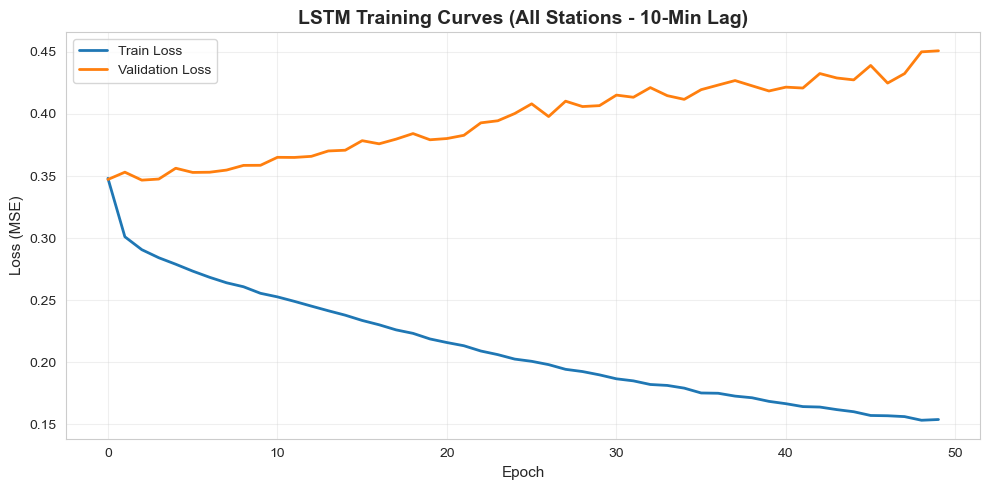

In [13]:
# Initialize model
model = MultiStationLSTM(n_stations=n_stations, lookback=lookback, hidden_size=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0
    for input_window, target in train_loader:
        optimizer.zero_grad()
        prediction = model(input_window)
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_window, target in val_loader:
            prediction = model(input_window)
            loss = criterion(prediction, target)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

# Load best model
model.load_state_dict(best_model_state)

print(f" Best validation loss: {best_val_loss:.6f}")

# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE)', fontsize=11)
ax.set_title('LSTM Training Curves (All Stations - 10-Min Lag)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_all_stations_10min_lag_training_curves.png', dpi=300, bbox_inches='tight')
print("  Saved: lstm_all_stations_10min_lag_training_curves.png")
plt.show()

### Prediction

In [14]:

# Predict on validation set
model.eval()
predictions_val_scaled = []

with torch.no_grad():
    for input_window, _ in val_loader:
        pred = model(input_window)
        predictions_val_scaled.append(pred.numpy())

predictions_val_scaled = np.vstack(predictions_val_scaled)  # (n_samples, n_stations)

# Un-standardize predictions
predictions_val = predictions_val_scaled * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN

# Get actual values (un-standardized)
actual_val_scaled = data_scaled_val[lookback + lag:]
actual_val = actual_val_scaled * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN

print(f"  Predictions shape: {predictions_val.shape}")
print(f"  Actual shape: {actual_val.shape}")

# Also predict on full dataset for visualization
predictions_full_scaled = np.zeros_like(all_data_scaled)
predictions_full_scaled[:] = np.nan  # Initialize with NaN

model.eval()
with torch.no_grad():
    for i in range(lookback + lag, len(all_data_scaled)):
        # Use data from [i-lookback-lag : i-lag]
        input_window = all_data_scaled[i-lookback-lag:i-lag]
        input_tensor = torch.FloatTensor(input_window).unsqueeze(0)
        pred = model(input_tensor).numpy().flatten()
        predictions_full_scaled[i] = pred

# Un-standardize full predictions
predictions_full = predictions_full_scaled * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN


  Predictions shape: (8620, 6)
  Actual shape: (8620, 6)


In [15]:
# Overall metrics
rmse_overall = np.sqrt(mean_squared_error(actual_val, predictions_val))
mae_overall = mean_absolute_error(actual_val, predictions_val)
r2_overall = r2_score(actual_val.flatten(), predictions_val.flatten())

print(f"\nOVERALL (All stations combined):")
print(f"  RMSE: {rmse_overall:.4f}")
print(f"  MAE:  {mae_overall:.4f}")
print(f"  R²:   {r2_overall:.4f}")

# Per-station metrics
print(f"\nPER-STATION RESULTS:")
print(f"{'Station':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 40)

for i, station in enumerate(all_stations):
    rmse_station = np.sqrt(mean_squared_error(actual_val[:, i], predictions_val[:, i]))
    mae_station = mean_absolute_error(actual_val[:, i], predictions_val[:, i])
    r2_station = r2_score(actual_val[:, i], predictions_val[:, i])
    
    print(f"{station:<10} {rmse_station:<10.4f} {mae_station:<10.4f} {r2_station:<10.4f}")

# Debris flow times only
debris_flow_indicator = df_june.groupby('time_minute')['debris flow'].max()
debris_flow_indicator = debris_flow_indicator.reindex(df_wide_all_filled.index).fillna(0)

debris_mask_val = debris_flow_indicator.values[temporal_split_idx + lookback + lag:] == 1

if debris_mask_val.sum() > 0:
    print(f"\nDEBRIS FLOW TIMES ONLY (Validation Set):")
    
    # Overall during debris flows
    rmse_debris = np.sqrt(mean_squared_error(
        actual_val[debris_mask_val], 
        predictions_val[debris_mask_val]
    ))
    mae_debris = mean_absolute_error(
        actual_val[debris_mask_val], 
        predictions_val[debris_mask_val]
    )
    r2_debris = r2_score(
        actual_val[debris_mask_val].flatten(), 
        predictions_val[debris_mask_val].flatten()
    )
    
    print(f"  OVERALL:")
    print(f"    RMSE: {rmse_debris:.4f}")
    print(f"    MAE:  {mae_debris:.4f}")
    print(f"    R²:   {r2_debris:.4f}")
    print(f"    Timepoints: {debris_mask_val.sum()}")
    
    # Per-station during debris flows
    print(f"\n  PER-STATION:")
    print(f"  {'Station':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
    print("  " + "-" * 40)
    
    for i, station in enumerate(all_stations):
        rmse_st = np.sqrt(mean_squared_error(
            actual_val[debris_mask_val, i], 
            predictions_val[debris_mask_val, i]
        ))
        mae_st = mean_absolute_error(
            actual_val[debris_mask_val, i], 
            predictions_val[debris_mask_val, i]
        )
        r2_st = r2_score(
            actual_val[debris_mask_val, i], 
            predictions_val[debris_mask_val, i]
        )
        
        print(f"  {station:<10} {rmse_st:<10.4f} {mae_st:<10.4f} {r2_st:<10.4f}")



OVERALL (All stations combined):
  RMSE: 0.0425
  MAE:  0.0236
  R²:   0.6368

PER-STATION RESULTS:
Station    RMSE       MAE        R²        
----------------------------------------
ILL13      0.0251     0.0165     0.7588    
ILL12      0.0223     0.0124     0.7621    
ILL16      0.0397     0.0219     -0.1527   
ILL18      0.0452     0.0265     0.2740    
ILL17      0.0736     0.0490     0.4546    
ILL11      0.0261     0.0152     0.7137    

DEBRIS FLOW TIMES ONLY (Validation Set):
  OVERALL:
    RMSE: 0.0802
    MAE:  0.0567
    R²:   0.5891
    Timepoints: 103

  PER-STATION:
  Station    RMSE       MAE        R²        
  ----------------------------------------
  ILL13      0.0274     0.0196     0.9556    
  ILL12      0.0574     0.0400     0.7129    
  ILL16      0.0870     0.0711     -0.8346   
  ILL18      0.1242     0.0928     -0.1287   
  ILL17      0.0943     0.0821     -1.6247   
  ILL11      0.0513     0.0348     0.9018    


  ✓ Saved: lstm_all_stations_10min_lag_timeseries.png


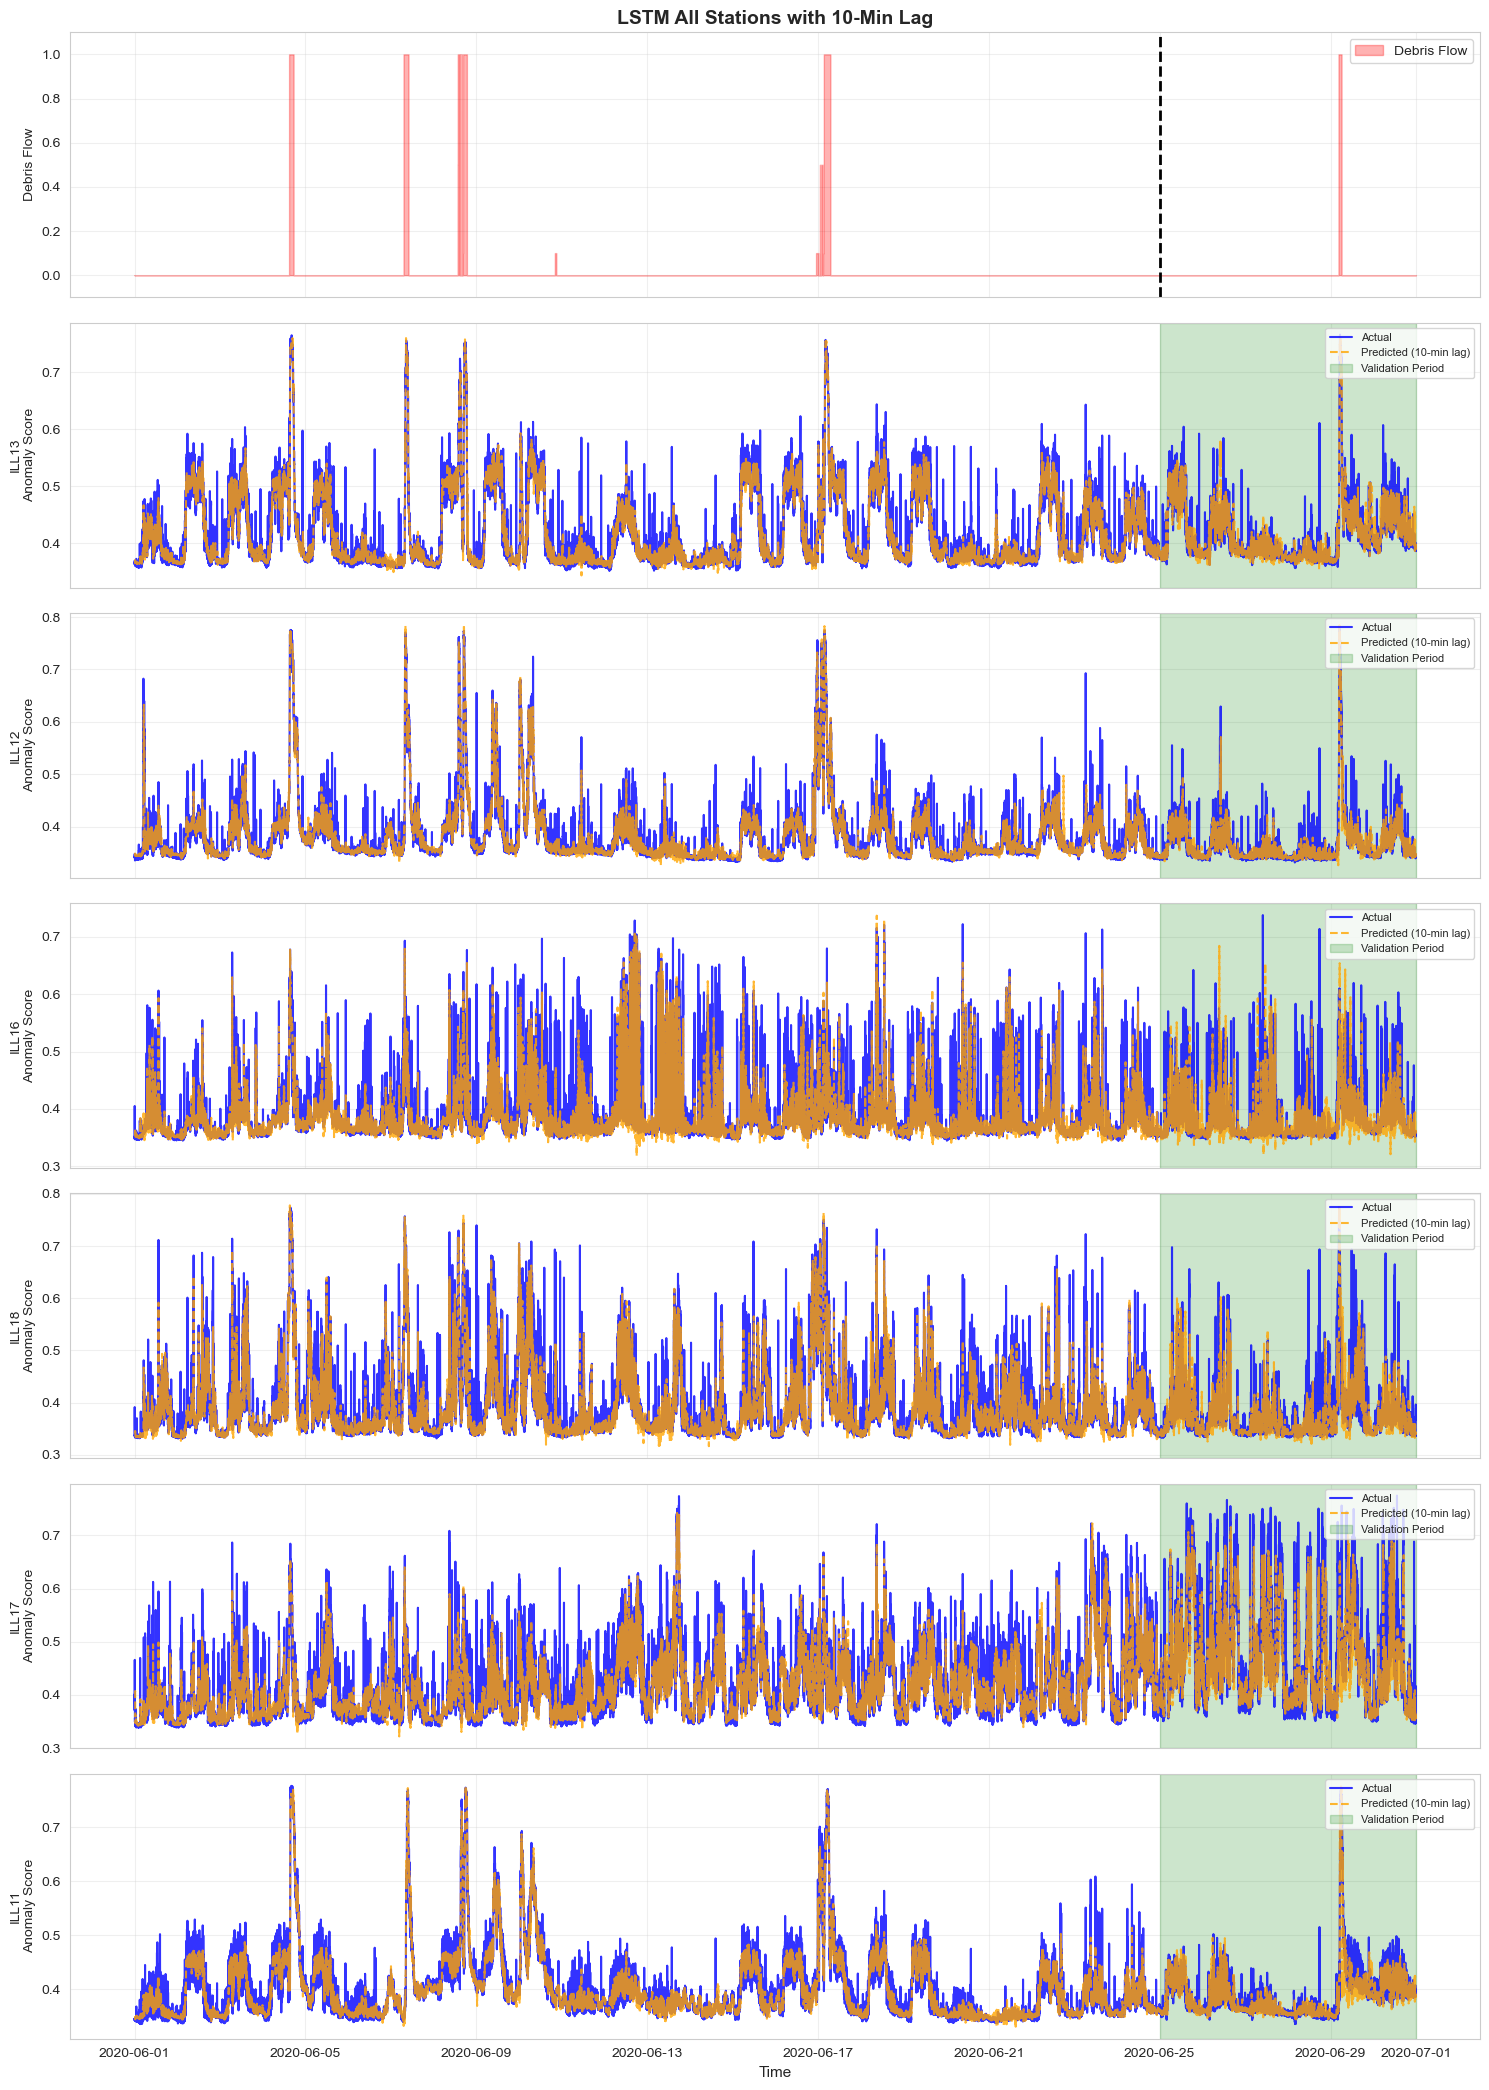

In [16]:
# Plot time series for each station
n_stations = len(all_stations)
fig, axes = plt.subplots(n_stations + 1, 1, figsize=(15, 3*(n_stations+1)), sharex=True)

# Debris flow indicator
axes[0].fill_between(df_wide_all_filled.index, 0, 
                     debris_flow_indicator.values, 
                     alpha=0.3, color='red', label='Debris Flow')
axes[0].set_ylabel('Debris Flow', fontsize=10)
axes[0].set_ylim([-0.1, 1.1])
axes[0].legend(loc='upper right')
axes[0].set_title('LSTM All Stations with 10-Min Lag', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add vertical line at train/val split
axes[0].axvline(df_wide_all_filled.index[temporal_split_idx], 
                color='black', linestyle='--', linewidth=2, label='Train/Val Split')

# Plot each station
for i, station in enumerate(all_stations):
    ax = axes[i+1]
    
    # Actual values
    ax.plot(df_wide_all_filled.index, df_wide_all_filled[station].values,
            label='Actual', linewidth=1.5, alpha=0.8, color='blue')
    
    # Predictions
    ax.plot(df_wide_all_filled.index, predictions_full[:, i],
            label='Predicted (10-min lag)', linewidth=1.5, alpha=0.8, 
            color='orange', linestyle='--')
    
    # Shade validation period
    ax.axvspan(df_wide_all_filled.index[temporal_split_idx], 
               df_wide_all_filled.index[-1],
               alpha=0.2, color='green', label='Validation Period')
    
    ax.set_ylabel(f'{station}\nAnomaly Score', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=11)

plt.tight_layout()
plt.savefig('lstm_all_stations_10min_lag_timeseries.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: lstm_all_stations_10min_lag_timeseries.png")
plt.show()

  ✓ Saved: lstm_all_stations_10min_lag_scatter.png


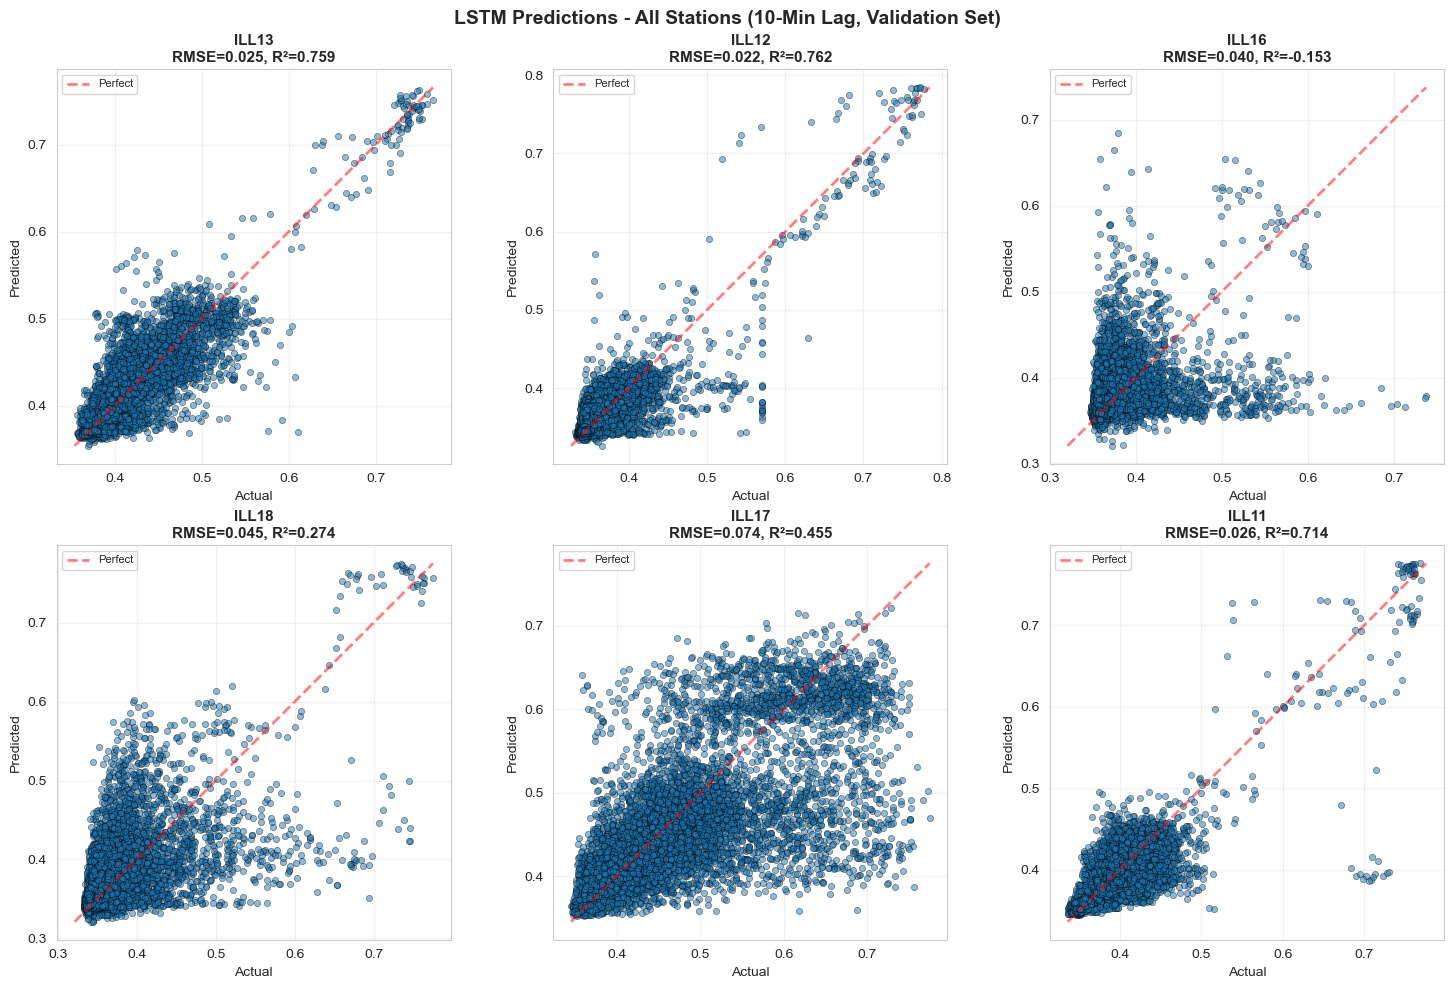

In [17]:
# Scatter plots for each station
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, station in enumerate(all_stations):
    ax = axes[i]
    
    # Validation data
    ax.scatter(actual_val[:, i], predictions_val[:, i], 
               alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    lims = [
        min(actual_val[:, i].min(), predictions_val[:, i].min()),
        max(actual_val[:, i].max(), predictions_val[:, i].max())
    ]
    ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect')
    
    # Metrics
    rmse_st = np.sqrt(mean_squared_error(actual_val[:, i], predictions_val[:, i]))
    r2_st = r2_score(actual_val[:, i], predictions_val[:, i])
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{station}\nRMSE={rmse_st:.3f}, R²={r2_st:.3f}', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.suptitle('LSTM Predictions - All Stations (10-Min Lag, Validation Set)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('lstm_all_stations_10min_lag_scatter.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: lstm_all_stations_10min_lag_scatter.png")
plt.show()

  ✓ Saved: lstm_all_stations_10min_lag_scatter_debris_flow.png


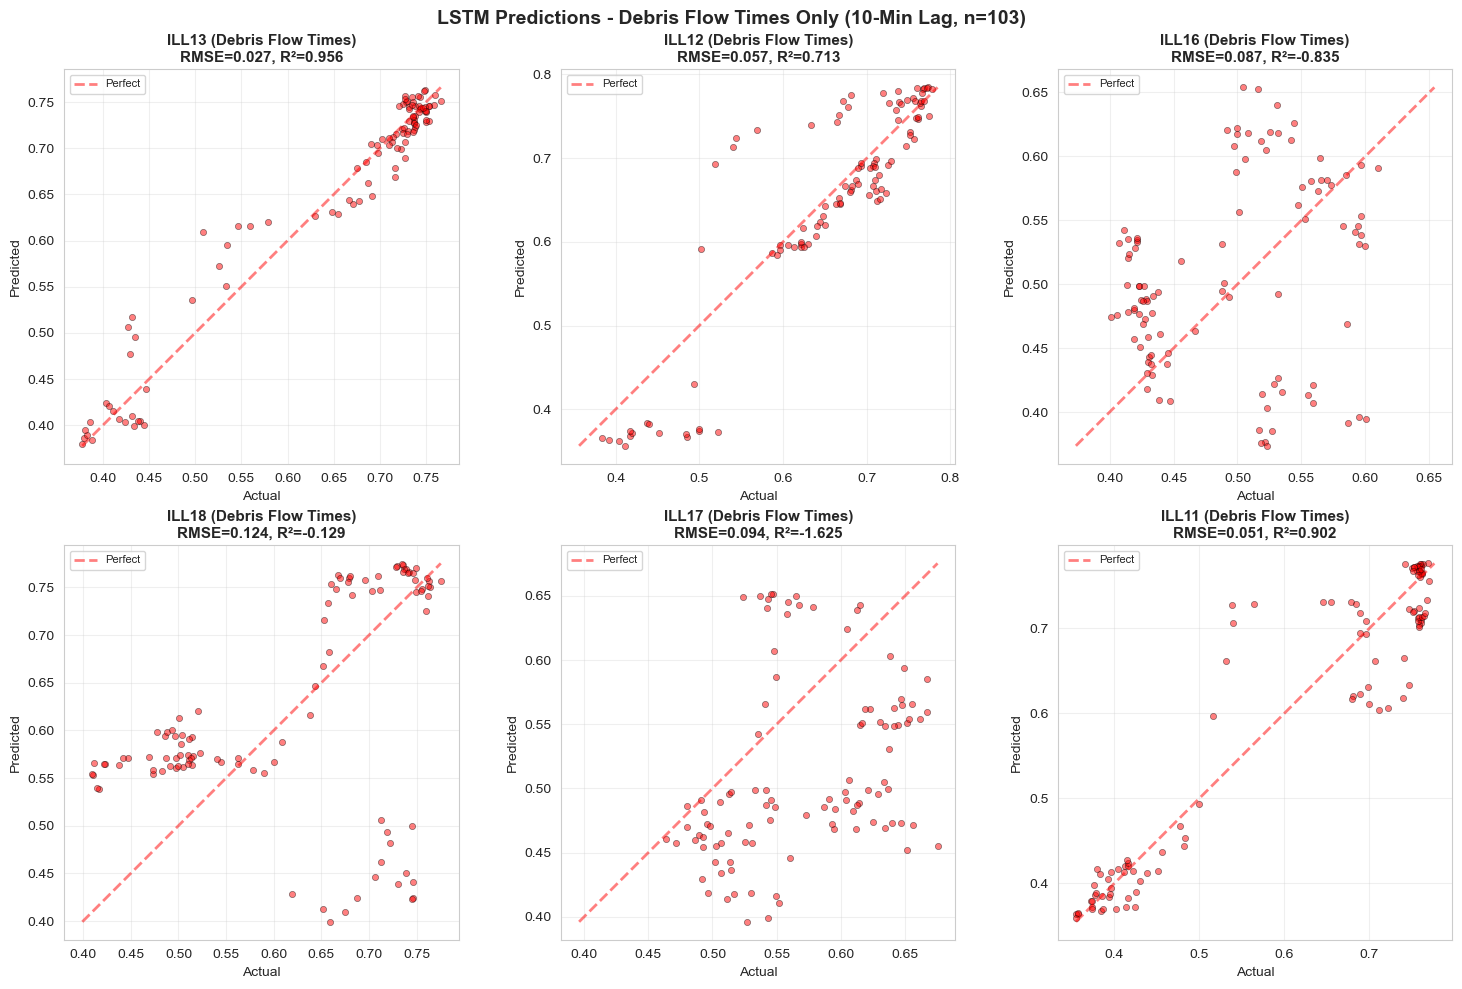

In [18]:
if debris_mask_val.sum() > 0:
    # Scatter plots for each station during debris flows
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, station in enumerate(all_stations):
        ax = axes[i]
        
        # Debris flow data only
        actual_debris = actual_val[debris_mask_val, i]
        pred_debris = predictions_val[debris_mask_val, i]
        
        ax.scatter(actual_debris, pred_debris, 
                   alpha=0.5, s=20, edgecolors='black', linewidth=0.5, color='red')
        
        # Perfect prediction line
        lims = [
            min(actual_debris.min(), pred_debris.min()),
            max(actual_debris.max(), pred_debris.max())
        ]
        ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect')
        
        # Metrics
        rmse_st = np.sqrt(mean_squared_error(actual_debris, pred_debris))
        r2_st = r2_score(actual_debris, pred_debris)
        
        ax.set_xlabel('Actual', fontsize=10)
        ax.set_ylabel('Predicted', fontsize=10)
        ax.set_title(f'{station} (Debris Flow Times)\nRMSE={rmse_st:.3f}, R²={r2_st:.3f}', 
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')
    
    plt.suptitle(f'LSTM Predictions - Debris Flow Times Only (10-Min Lag, n={debris_mask_val.sum()})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('lstm_all_stations_10min_lag_scatter_debris_flow.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: lstm_all_stations_10min_lag_scatter_debris_flow.png")
    plt.show()
else:
    print("  ⚠️  No debris flow events in validation set")